In [50]:
import pandas as pd
import json
import string
import math
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#from google.colab import files
#uploaded = files.upload()
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [52]:
#Getting the 2% yelp review file (mixed)
link='https://drive.google.com/open?id=1UZrJemORwgEb4mVyVdtkbqOt-VYrgIg7'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('review_csv_2%.csv')

1UZrJemORwgEb4mVyVdtkbqOt-VYrgIg7


In [53]:
#Getting the 2% yelp review file (mixed) - with equal rating distribution
link='https://drive.google.com/open?id=1rsJIyZ5tggwFDKYqQ_A3sOSDV6cilXRq'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('review_eq_2%.csv')

1rsJIyZ5tggwFDKYqQ_A3sOSDV6cilXRq


In [54]:
#Getting the 2% food review file
link='https://drive.google.com/open?id=1jZVzy52gDqnPcSmvwfsDJ6GxKOWa6Rgq'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('review_food_2%.csv')

1jZVzy52gDqnPcSmvwfsDJ6GxKOWa6Rgq


In [55]:
#Getting the 2% food review file - with equal rating distribution
link='https://drive.google.com/open?id=1VepmxxaKAhx6Yl9C66N2xrVM0g38CzJR'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('review_foodeq_2%.csv')

1VepmxxaKAhx6Yl9C66N2xrVM0g38CzJR


In [56]:
#Getting the yelp business file 2018
link='https://drive.google.com/open?id=1gTdgoZUc4y03im0g6KN41lK672alKKvi'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('yelp_business.csv')

1gTdgoZUc4y03im0g6KN41lK672alKKvi


In [57]:
#Reading the review file to panda
yelp_2_review_data = pd.read_csv('review_csv_2%.csv', sep=",", index_col=0)
yelp_2_review_data = yelp_2_review_data.reset_index(drop=True) #re-indexing
yelp_2_review_data.sample(n=5)    # Randomly select n=5 rows and return them

# #Reading the business file
# df_business = pd.read_csv('yelp_business.csv',delimiter=",")

# #Appending the business categories to the review dataframe
# yelp_2_review_data=pd.merge(yelp_2_review_data, df_business[['business_id','categories']], on='business_id',how='left')
# yelp_2_review_data['categories']=yelp_2_review_data['categories'].str.replace('[^a-zA-Z]', ' ')   #removing punctuation and symbols
# yelp_2_review_data['categories']= yelp_2_review_data['categories'].str.lower()    #converting to lowercase
# yelp_2_review_data.sample(n=5)    # Randomly select n=5 rows and return them

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,categories
80983,YcXVqEQSldXsGr904fWyLA,FoLaxhgAf0MjObrN34SeBQ,vKiJDmyzcASYgYizjEpsAg,1,2015-02-18,I wish I would have shelled out the extra 5 do...,6,1,0,hotels travel car rental
91075,uGjJ_gIGZ7ZoFzcTYIXOMg,2zC7h8dsiQ44PHwHK3Kjww,V4YBWutY9j3ONvrTH-EhMg,2,2012-01-15,"I really dislike going here, but what other op...",0,1,2,beer wine spirits restaurants drugstores sho...
39449,cDEBWtOrlkmk-bo2TMGtAg,uKwseO-7T_Hqwf0YQ_etNw,KOAYl73BQ-2tQe0Q-SA9jQ,1,2012-04-29,Worst service in the city. Our group of four -...,6,3,1,restaurants japanese
30608,Hmd9glF8dC3tpNRJZbUryw,v85lG0H5yoI52k3g10T3Mg,fcyk-PZKRqo4EUJ0vH1aNg,1,2015-02-04,Called and ordered a pizza at 7pm and it still...,0,0,0,burgers pizza chicken wings restaurants
48762,PxNMCla2Dvgx1JmrI8OPVQ,nJKYd6NTQGWTAICvdEjcIA,D3tXmFzqLD3mGzYnp5vp7w,5,2013-06-23,Can't rave enough about this place! I was so e...,0,0,0,japanese vegan sushi bars restaurants


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


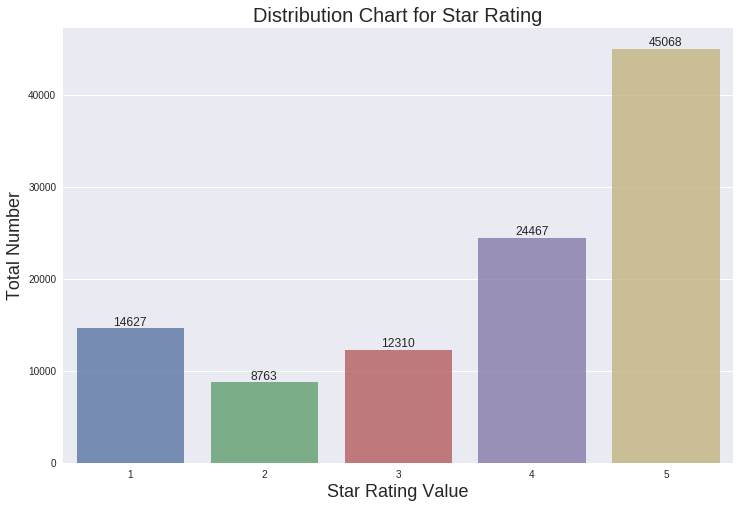

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# checking the Star rating distribution of dataset

dist = yelp_2_review_data['stars'].value_counts()
dist = dist.sort_index()

# Plotting the Distribution
plt.figure(figsize=(12,8))
ax = sns.barplot(dist.index, dist.values, alpha=0.8)
plt.title("Distribution Chart for Star Rating", fontsize=20)
plt.ylabel("Total Number", fontsize=18)
plt.xlabel("Star Rating Value", fontsize=18)

rects = ax.patches
labels = dist.values
for rect, label in zip(rects, labels):
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
  
plt.show()

In [59]:
#CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE REVIEW
yelp_2_review_data['length'] = yelp_2_review_data['text'].apply(len)
yelp_2_review_data.head(2)

,review_id,user_id,business_id,stars,date,text,useful,funny,cool,categories,length
0,i8RhpEgalkeY97p0YQ0JeA,OzGlDEQ_vzH8QU9NBRs-pw,HxLouUPqiou7D6YK5t-DgQ,3,2011-03-06,"Pretty good, but it'll cost ya.\r\n\r\nThe Fre...",1,0,1,wine bars tapas bars canadian new bars night...,765
1,RH_VhBzxegIWT_crf9ButA,lxt4LomsbAjBvk5POhDTEw,giptYxR9l72ogEKaxqch4A,4,2011-05-30,Boyfriend had planned to pick up some sort of ...,8,6,6,food beer wine spirits,708


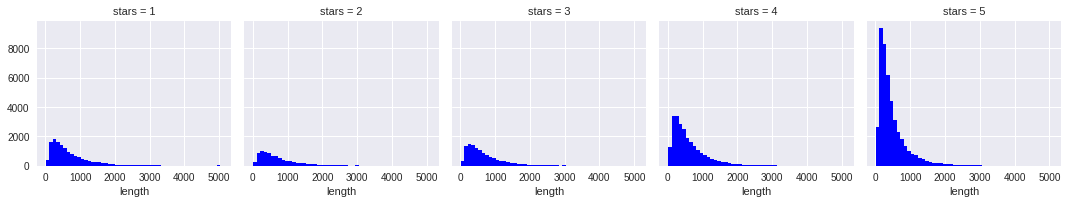

In [60]:
# COMPARING TEXT LENGTH TO STARS
graph = sns.FacetGrid(data=yelp_2_review_data,col='stars')
graph.map(plt.hist,'length',bins=50,color='blue')

In [61]:
# GETTING THE MEAN VALUES OF THE VOTE COLUMNS WRT THE STARS ON THE REVIEW
stval = yelp_2_review_data.groupby('stars').mean()
stval

,useful,funny,cool,length
stars,,,,
1,2.288576,0.701579,0.277706,770.819307
2,1.583818,0.666895,0.392674,765.696223
3,1.368968,0.628432,0.688383,717.960764
4,1.371766,0.579066,0.846773,635.976662
5,1.107992,0.356949,0.579169,494.594391


In [62]:
# FINDING THE CORRELATION BETWEEN THE VOTE COLUMNS
stval.corr()

,useful,funny,cool,length
useful,1.000000,0.747709,-0.727590,0.737092
funny,0.747709,1.000000,-0.380144,0.982938
cool,-0.727590,-0.380144,1.000000,-0.488970
length,0.737092,0.982938,-0.488970,1.000000


In [0]:
df=yelp_2_review_data.copy()

# Convert text to lowercase
df.loc[:,'text'] = df['text'].str.lower()

# Remove punctuation
df ['text']= df ['text'].str.replace('[^a-zA-Z]', ' ')

**Stem and remove stop words**

In [0]:
# Create the lemmatizer and the different stemmers
snowball = SnowballStemmer("english")
porter = PorterStemmer()
lancaster=LancasterStemmer()
lemmatizer = WordNetLemmatizer()

**Define the 7 different tokenizing function for the TFIDFVectorizer **

In [0]:
# Porter Stemmer tokens ---------------------------------------------
def portertokens(x):
    x = x.split()
    stems = []
    [stems.append(porter.stem(word)) for word in x]
    return stems

In [0]:
# Snowball Stemmer tokens ---------------------------------------------
def snowballtokens(x):
    x = x.split()
    stems = []
    [stems.append(snowball.stem(word)) for word in x]
    return stems

In [0]:
# Lancaster Stemmer tokens ---------------------------------------------
def lancastertokens(x):
    x = x.split()
    stems = []
    [stems.append(lancaster.stem(word)) for word in x]
    return stems

In [0]:
# Lemmetization tokens ---------------------------------------------
def lemmatizertokens(x):
    x = x.split()
    stems = []
    [stems.append(lemmatizer.lemmatize(word,pos="a")) for word in x]
    return stems

In [0]:
# Porter Stemmer & Lemmitization tokens ------------------------------------
def portlemtokens(x):
    x = x.split()
    stems = []
    [stems.append(porter.stem(lemmatizer.lemmatize(word,pos="a"))) for word in x]
    return stems

In [0]:
# Snowball Stemmer & Lemmitization tokens ----------------------------------
def snowlemtokens(x):
    x = x.split()
    stems = []
    [stems.append(snowball.stem(lemmatizer.lemmatize(word,pos="a"))) for word in x]
    return stems

In [0]:
# Lancaster Stemmer & Lemmitization tokens ----------------------------------
def lanlemtokens(x):
    x = x.split()
    stems = []
    [stems.append(lancaster.stem(lemmatizer.lemmatize(word,pos="a"))) for word in x]
    return stems

**Develop features array**

In [72]:
# Define the vectorizer
vectorizer = TfidfVectorizer(tokenizer = portlemtokens, stop_words = 'english', ngram_range=(1,2), max_features=None,  min_df = 0.01)

# Fit the vectorizers to the data
feature_words = vectorizer.fit_transform(df['text'])

features = pd.DataFrame(feature_words.toarray(), columns = vectorizer.get_feature_names())
features = pd.concat([features, df[['stars']]], axis = 1)
features.sample(n=5)


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_wor

,abl,abov,absolut,accommod,actual,ad,add,addit,afford,afternoon,...,write,wrong,ye,year,year ago,yelp,young,yum,yummi,stars
36822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,4
21936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,5
16759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,4
24845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.107482,0.167931,0.0,0.0,0.0,0.0,2
5090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,5


In [73]:
# CLASSIFICATION AS KAGGLE EXAMPLE WITH ONLY 3 CLASSES
x = features[(features['stars']==1) | (features['stars']==3) | (features['stars']==5)]
y=x.loc[:,'stars']
print(x.shape)


from sklearn.model_selection import train_test_split, cross_val_score
# SPLITTING THE DATASET INTO TRAINING SET AND TESTING SET
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify= x['stars'],random_state=101)

#Seperating the stars
y_train=x_train.loc[:,'stars']
y_test=x_test.loc[:,'stars']

#Dropping the stars from the x features
x_train=x_train.drop(columns=['stars'])
x_test=x_test.drop(columns=['stars'])

(72005, 933)


In [0]:
# # CLASSIFICATION WITH ALL 5 STAR CLASSES
# x = features.copy()
# y=x.loc[:,'stars']
# print(x.shape)

# from sklearn.model_selection import train_test_split, cross_val_score
# # SPLITTING THE DATASET INTO TRAINING SET AND TESTING SET
# x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify= x['stars'],random_state=101)

# #Dropping the stars from the x features
# x_train=x_train.drop(columns=['stars'])
# x_test=x_test.drop(columns=['stars'])

In [106]:
%%time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
#from sklearn.grid_search import GridSearchCV

# Random Forest
from sklearn.ensemble import RandomForestClassifier
#rmfr = RandomForestClassifier(random_state=56)
rmfr = RandomForestClassifier(criterion= 'gini', max_depth= None,
                              min_samples_leaf= 3, min_samples_split=2,
                              n_estimators= 100,n_jobs=-1, random_state=56)
rmfr.fit(x_train,y_train)
predrmfr = rmfr.predict(x_test)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrmfr))
print("Score:",round(accuracy_score(y_test,predrmfr)*100,2))
print("Classification Report:")
print(classification_report(y_test,predrmfr))

Confusion Matrix for Random Forest Classifier:
[[ 3268   219   901]
 [  501  1238  1954]
 [  276   190 13055]]
Score: 81.29
Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.74      0.78      4388
           3       0.75      0.34      0.46      3693
           5       0.82      0.97      0.89     13521

   micro avg       0.81      0.81      0.81     21602
   macro avg       0.79      0.68      0.71     21602
weighted avg       0.81      0.81      0.79     21602

CPU times: user 2min, sys: 447 ms, total: 2min
Wall time: 2min


In [0]:
%timeit

# K Nearest Neighbour Algorithm
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(x_train,y_train)
# predknn = knn.predict(x_test)
# print("Confusion Matrix for K Neighbors Classifier:")
# print(confusion_matrix(y_test,predknn))
# print("Score: ",round(accuracy_score(y_test,predknn)*100,2))
# print("Classification Report:")
# print(classification_report(y_test,predknn))

In [77]:
# XGBoost Classifier
import xgboost
from xgboost import XGBClassifier
# xgb = XGBClassifier()
xgb = XGBClassifier(colsample_bytree=1,gamma=0.5,max_depth= 3,
                    min_child_weight= 3,subsample=1, 
                    n_estimators=100,nthread=1)
xgb.fit(x_train,y_train)
predxgb = xgb.predict(x_test)
print("Confusion Matrix for XGBoost Classifier:")
print(confusion_matrix(y_test,predxgb))
print("Score: ",round(accuracy_score(y_test,predxgb)*100,2))
print("Classification Report:")
print(classification_report(y_test,predxgb))


Confusion Matrix for XGBoost Classifier:
[[ 2841   291  1256]
 [  394  1443  1856]
 [  226   299 12996]]
Score:  79.99
Classification Report:
              precision    recall  f1-score   support

           1       0.82      0.65      0.72      4388
           3       0.71      0.39      0.50      3693
           5       0.81      0.96      0.88     13521

   micro avg       0.80      0.80      0.80     21602
   macro avg       0.78      0.67      0.70     21602
weighted avg       0.79      0.80      0.78     21602



In [78]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(x_train,y_train)
predmnb = mnb.predict(x_test)
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:")
print(classification_report(y_test,predmnb))

Confusion Matrix for Multinomial Naive Bayes:
[[ 3006   361  1021]
 [  352  1344  1997]
 [  218   155 13148]]
Score: 81.0
Classification Report:
              precision    recall  f1-score   support

           1       0.84      0.69      0.75      4388
           3       0.72      0.36      0.48      3693
           5       0.81      0.97      0.89     13521

   micro avg       0.81      0.81      0.81     21602
   macro avg       0.79      0.67      0.71     21602
weighted avg       0.80      0.81      0.79     21602



In [0]:
# Decision Tree
# from sklearn.tree import DecisionTreeClassifier
# dt = DecisionTreeClassifier()
# dt.fit(x_train,y_train)
# preddt = dt.predict(x_test)
# print("Confusion Matrix for Decision Tree:")
# print(confusion_matrix(y_test,preddt))
# print("Score:",round(accuracy_score(y_test,preddt)*100,2))
# print("Classification Report:")
# print(classification_report(y_test,preddt))

In [0]:
# MULTILAYER PERCEPTRON CLASSIFIER
# from sklearn.neural_network import MLPClassifier
# mlp = MLPClassifier()
# mlp.fit(x_train,y_train)
# predmlp = mlp.predict(x_test)
# print("Confusion Matrix for Multilayer Perceptron Classifier:")
# print(confusion_matrix(y_test,predmlp))
# print("Score:",round(accuracy_score(y_test,predmlp)*100,2))
# print("Classification Report:")
# print(classification_report(y_test,predmlp))

In [0]:
# # Gradient Boosting Classifier
# from sklearn.ensemble import GradientBoostingClassifier
# gbi = GradientBoostingClassifier(learning_rate=0.1,max_depth=5,max_features=0.5,random_state=999999)
# gbi.fit(x_train,y_train)
# predgbi = gbi.predict(x_test)
# print("Confusion Matrix for Gradient Boosting Classifier:")
# print(confusion_matrix(y_test,predgbi))
# print("Score:",round(accuracy_score(y_test,predgbi)*100,2))
# print("Classification Report:")
# print(classification_report(y_test,predgbi))

In [82]:
from sklearn.ensemble import VotingClassifier

ens = VotingClassifier(estimators=[('nb',mnb), ('rf',rmfr), ('gb',xgb)], voting='soft')
# perceptron
ens.fit(x_train,y_train)
predens = ens.predict(x_test)
print("Confusion Matrix for Ensemmble:")
print(confusion_matrix(y_test,predens))
print("Score:",round(accuracy_score(y_test,predens)*100,2))
print("Classification Report:")
print(classification_report(y_test,predens))

Confusion Matrix for Ensemmble:
[[ 3133   261   994]
 [  373  1373  1947]
 [  190   176 13155]]
Score: 81.76
Classification Report:
              precision    recall  f1-score   support

           1       0.85      0.71      0.78      4388
           3       0.76      0.37      0.50      3693
           5       0.82      0.97      0.89     13521

   micro avg       0.82      0.82      0.82     21602
   macro avg       0.81      0.69      0.72     21602
weighted avg       0.81      0.82      0.80     21602



In [83]:
from sklearn.ensemble import VotingClassifier

ens = VotingClassifier(estimators=[('nb',mnb), ('rf',rmfr), ('gb',xgb)], voting='hard')
# perceptron
ens.fit(x_train,y_train)
predens = ens.predict(x_test)
print("Confusion Matrix for Ensemmble:")
print(confusion_matrix(y_test,predens))
print("Score:",round(accuracy_score(y_test,predens)*100,2))
print("Classification Report:")
print(classification_report(y_test,predens))

Confusion Matrix for Ensemmble:
[[ 3138   250  1000]
 [  477  1320  1896]
 [  230   185 13106]]
Score: 81.31
Classification Report:
              precision    recall  f1-score   support

           1       0.82      0.72      0.76      4388
           3       0.75      0.36      0.48      3693
           5       0.82      0.97      0.89     13521

   micro avg       0.81      0.81      0.81     21602
   macro avg       0.80      0.68      0.71     21602
weighted avg       0.81      0.81      0.79     21602



In [84]:
count = yelp_2_review_data['stars'].value_counts()
print(count)

5    45068
4    24467
1    14627
3    12310
2     8763
Name: stars, dtype: int64


In [105]:
# NEGATIVE REVIEW
nr = yelp_2_review_data['text'][16]
print(nr)
print("Actual Rating: ",yelp_2_review_data['stars'][16])
# Convert text to lowercase
nr = nr.lower()
# Remove punctuation
nr =nr.replace('[^a-zA-Z]', ' ')
vectorizer = TfidfVectorizer(tokenizer = portlemtokens, stop_words = 'english', ngram_range=(1,2), max_features=None,  min_df = 0.01)
nr_t = vectorizer.transform([nr])
# nr_p = pd.DataFrame(nr_t.toarray(), columns = vectorizer.get_feature_names())
# c=nr_p.columns.intersection(x_train.columns)
# print(c.size)
print("Predicted Rating:")
mnb.predict(nr_t)[0]
# nr_t = vectorizer.fit_transform([nr])
# print("Predicted Rating:")
# mnb.predict(nr_t)

It's airport food. I've come to not expect much when dining at McCarron. The typical experience held true. Not overly clean (pieces of dried food left on silverware in this case we well as silverware and napkins under our "clean" table) and no real sense that anyone cares that you are there. But I guess when you have a captive audience, why try?

The positives about this experience were the food - my Mediterranean-influenced grilled chicken salad was very tasty. The chicken was dry but flavorful, the kalamata olives were sliced very tiny, but plentiful and the dressing was light in texture. All over, a great value for the quality and location ($11). My husbands pepperoni pizza was also a nice surprise. The pepperoni had a bit of zing to it and the cheese and sauce seemed fresh in taste. We both had water and found it odd that both glasses came with zero ice. 

Our server was pleasant and while the service wasn't terrific, she sure was better than some service we've had in airports.

So

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_wor

ValueError: ignored

In [0]:
# AVERAGE REVIEW
ar = yelp_2_review_data['text'][16]
print(ar)
print("Actual Rating: ",yelp_2_review_data['stars'][16])
ar_t = vectorizer.fit_transform([ar])
print("Predicted Rating:")
mlp.predict(ar_t)[0]

In [0]:
# POSITIVE REVIEW
pr = yelp_2_review_data['text'][0]
print(pr)
print("Actual Rating: ",yelp_2_review_data['stars'][0])
pr_t = vectorizer.fit_transform([pr])
print("Predicted Rating:")
mlp.predict(pr_t)[0]